In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay

from mpitree.tree import DecisionTreeClassifier

In [2]:
np.random.seed(42)

In [3]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target

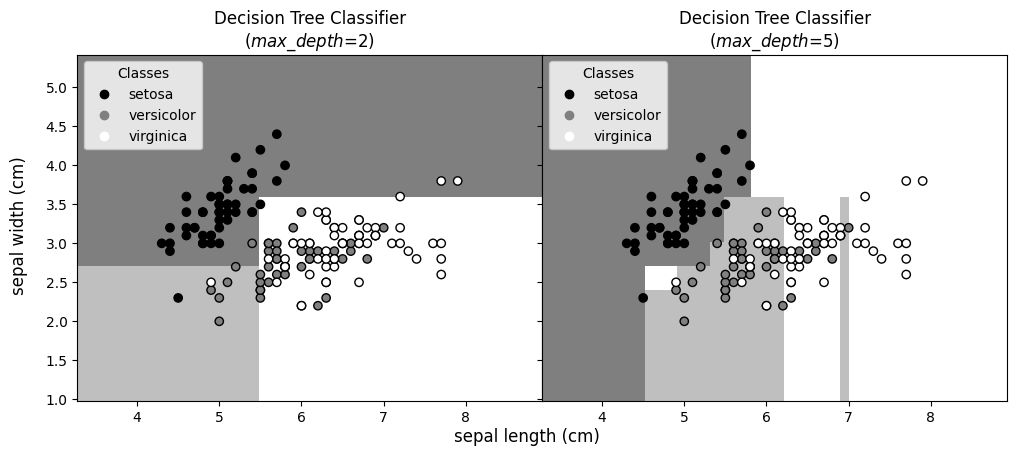

In [4]:
fig, axs = plt.subplots(
    ncols=2,
    sharex="col",
    sharey="row",
    figsize=(12, 4.5),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for ax, depth in zip(axs, (2, 5)):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.5,
        ax=ax,
        cmap="gray",
    )
    scatter = disp.ax_.scatter(
        X[:, 0], X[:, 1], cmap="gray", c=iris.target, edgecolors="k"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="upper left",
        title="Classes",
    )
    _ = disp.ax_.set_title(f"Decision Tree Classifier\n($max\_depth$={depth})")

fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)", x=0.069)

plt.show()

In [5]:
clf = DecisionTreeClassifier().fit(X, y)
print(clf)
print(f"Train Accuracy: {clf.score(X, y):.2%}")

┌── feature_0
│  ├── feature_1 [> 5.5]
│  │  ├── feature_0 [> 3.6]
│  │  │  └── class: 2 [> 5.8]
│  │  │  └── class: 0 [<= 5.8]
│  │  ├── feature_0 [<= 3.6]
│  │  │  ├── feature_0 [> 6.2]
│  │  │  │  ├── feature_0 [<= 7.0]
│  │  │  │  │  ├── feature_1 [<= 6.9]
│  │  │  │  │  │  ├── feature_0 [> 2.3]
│  │  │  │  │  │  │  ├── feature_1 [> 6.5]
│  │  │  │  │  │  │  │  ├── feature_0 [<= 3.1]
│  │  │  │  │  │  │  │  │  ├── feature_1 [> 6.6]
│  │  │  │  │  │  │  │  │  │  ├── feature_1 [> 2.5]
│  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 2.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [> 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [<= 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_1 [<= 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [> 3.0]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 3.0]
│  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 2.8]
│  │  │  │  │  │  │  │  │  │  └── class